In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json

<p span style="color:#ADD8E6; font-size:30px">
<i>Loading dataset</i>  
</p

In [4]:

# Load the dataset
file_path = r'C:\Users\izama\Desktop\machine learning\data\properties.csv'
data = pd.read_csv(file_path)

#Show all columns
pd.set_option('display.max_columns', None)

# Make s copy of the dataset to work on
data_copy = data.copy()

# Show basic information
data_copy.info()
data_copy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75511 entries, 0 to 75510
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              75511 non-null  int64  
 1   price                           75511 non-null  float64
 2   property_type                   75511 non-null  object 
 3   subproperty_type                75511 non-null  object 
 4   region                          75511 non-null  object 
 5   province                        75511 non-null  object 
 6   locality                        75511 non-null  object 
 7   zip_code                        75511 non-null  int64  
 8   latitude                        61413 non-null  float64
 9   longitude                       61413 non-null  float64
 10  construction_year               42120 non-null  float64
 11  total_area_sqm                  67896 non-null  float64
 12  surface_land_sqm                

,id,price,property_type,subproperty_type,region,province,locality,zip_code,latitude,longitude,construction_year,total_area_sqm,surface_land_sqm,nbr_frontages,nbr_bedrooms,equipped_kitchen,fl_furnished,fl_open_fire,fl_terrace,terrace_sqm,fl_garden,garden_sqm,fl_swimming_pool,fl_floodzone,state_building,primary_energy_consumption_sqm,epc,heating_type,fl_double_glazing,cadastral_income
0,34221000,225000.0,APARTMENT,APARTMENT,Flanders,Antwerp,Antwerp,2050,51.217172,4.379982,1963.0,100.0,NaN,2.0,2.0,INSTALLED,0,0,1,5.0,0,0.0,0,0,MISSING,231.0,C,GAS,1,922.0
1,2104000,449000.0,HOUSE,HOUSE,Flanders,East Flanders,Gent,9185,51.174944,3.845248,NaN,NaN,680.0,NaN,2.0,MISSING,0,0,0,0.0,0,0.0,0,0,MISSING,221.0,C,MISSING,1,406.0
2,34036000,335000.0,APARTMENT,APARTMENT,Brussels-Capital,Brussels,Brussels,1070,50.842043,4.334543,NaN,142.0,NaN,2.0,3.0,INSTALLED,0,0,1,NaN,0,0.0,0,1,AS_NEW,NaN,MISSING,GAS,0,NaN
3,58496000,501000.0,HOUSE,HOUSE,Flanders,Antwerp,Turnhout,2275,51.238312,4.817192,2024.0,187.0,505.0,NaN,3.0,MISSING,0,0,0,0.0,0,0.0,0,1,MISSING,99.0,A,MISSING,0,NaN
4,48727000,982700.0,APARTMENT,DUPLEX,Wallonia,Walloon Brabant,Nivelles,1410,NaN,NaN,2022.0,169.0,NaN,2.0,2.0,HYPER_EQUIPPED,0,0,1,20.0,1,142.0,0,0,AS_NEW,19.0,A+,GAS,0,NaN


<p span style="color:#ADD8E6; font-size:30px">
<i>Removing columns</i>  
</p

In [5]:
# Removing columns that have a lot of 'MISSING' values ​​and do not have such an impact on price prediction.
data_copy.drop(columns=['heating_type', 'equipped_kitchen', 'terrace_sqm', 'nbr_frontages'], inplace=True)

# Removing columns that have not such an impact on price prediction.
data_copy.drop(columns=['property_type', 'fl_furnished', 'latitude', 'longitude', 'cadastral_income', 
                        'fl_double_glazing', 'primary_energy_consumption_sqm', 'fl_floodzone'], inplace=True)

<p style="color:#ADD8E6; font-size:30px;">
<i>Focusing on Houses and Apartments for Price Prediction</i>
</p>

Since the goal of our analysis and model is to predict prices specifically for houses and apartments, all other property types have been excluded from the dataset. Houses and apartments represent the majority of the data and are the most commonly sought-after property types, making them the primary focus of our pricing analysis. By limiting our data to these two types, we ensure that our model remains streamlined and accurate, tailoring its predictions to the most relevant market segments.


In [6]:
# Define the allowed subproperty types (HOUSE and APARTMENT)
allowed_subproperty_types = ['HOUSE', 'APARTMENT']

# Filter the data to keep only rows with subproperty_type as HOUSE or APARTMENT
data_copy = data_copy[data_copy['subproperty_type'].isin(allowed_subproperty_types)].copy()

# Check the size of the cleaned dataset
print(f"Original dataset size: {len(data)}")
print(f"Dataset size (only HOUSE and APARTMENT): {len(data_copy)}")
print(data_copy['subproperty_type'].value_counts())

Original dataset size: 75511
Dataset size (only HOUSE and APARTMENT): 58490
subproperty_type
HOUSE        29730
APARTMENT    28760
Name: count, dtype: int64


<p span style="color:#ADD8E6; font-size:30px">
<i>Checking duplicates</i>  
</p>  

In [7]:
# Detecting duplicate rows in the DataFrame
def detect_duplicates(data_copy):
    duplicates = data_copy[data_copy.duplicated()]
    return duplicates

# Find duplicate rows
duplicates = detect_duplicates(data_copy)

# Display the number of duplicate rows
print(f"The DataFrame has {len(duplicates)} duplicate rows")

# Optionally, display the duplicate rows
if len(duplicates) > 0:
    print("Duplicate rows:")
    print(duplicates)

# Remove duplicates if necessary (optional)
data_copy = data_copy.drop_duplicates()


The DataFrame has 0 duplicate rows


<p span style="color:#ADD8E6; font-size:30px">
<i>Checking outliers</i>  
</p>  

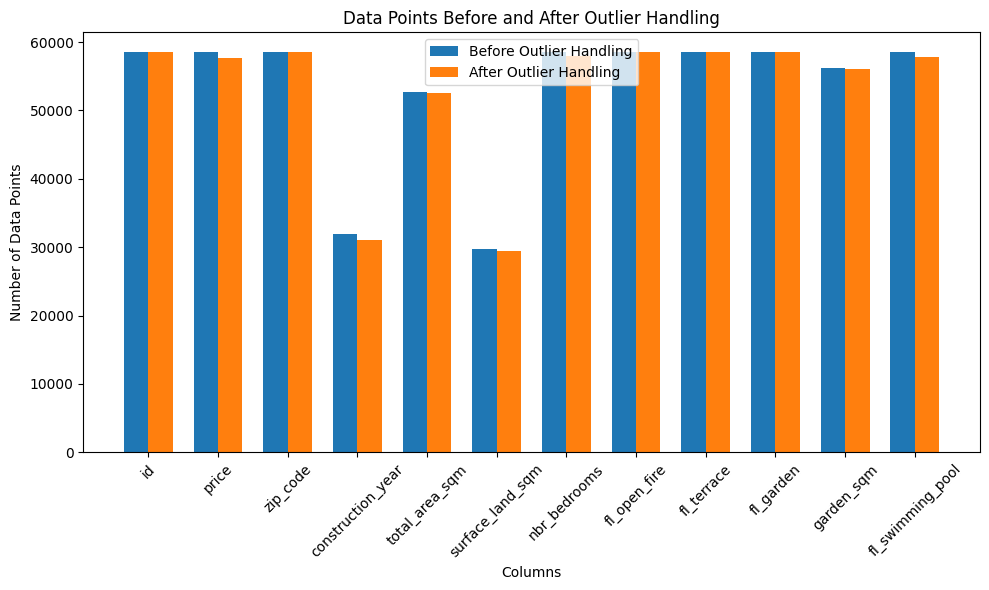

In [8]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt

# Detecting potential outliers and setting them to NaN
def set_outliers_to_nan(df, columns, threshold=3):
    df_no_outliers = df.copy()
    for col in columns:
        z_scores = zscore(df_no_outliers[col].fillna(df_no_outliers[col].mean()))
        mask = (z_scores > threshold) | (z_scores < -threshold)
        df_no_outliers.loc[mask, col] = np.nan  # Set outliers to NaN
    return df_no_outliers
"""
# Function to visualize outliers using a boxplot
def visualize_outliers_boxplot(df, columns, title_suffix=""):
    for col in columns:
        plt.figure(figsize=(8, 6))
        plt.boxplot(df[col].dropna(), vert=False, patch_artist=True)
        plt.title(f"Boxplot of '{col}' {title_suffix}")
        plt.xlabel(col)
        plt.show()
"""

# Select numeric columns for outlier detection
numeric_columns = data_copy.select_dtypes(include=['float64', 'int']).columns

# Count data points before outlier handling
data_points_before = {col: data_copy[col].count() for col in numeric_columns}

# Detect and set outliers to NaN
data_copy_no_outliers = set_outliers_to_nan(data_copy, numeric_columns)

# Count data points after setting outliers to NaN
data_points_after = {col: data_copy_no_outliers[col].count() for col in numeric_columns}

"""
# Visualize columns after outlier handling
visualize_outliers_boxplot(data_copy_no_outliers, numeric_columns, title_suffix="after Outlier Handling")
"""

# Plot number of data points before and after outlier handling
columns = list(data_points_before.keys())
counts_before = list(data_points_before.values())
counts_after = list(data_points_after.values())

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(columns))

plt.bar(index, counts_before, bar_width, label='Before Outlier Handling')
plt.bar(index + bar_width, counts_after, bar_width, label='After Outlier Handling')

plt.xlabel('Columns')
plt.ylabel('Number of Data Points')
plt.title('Data Points Before and After Outlier Handling')
plt.xticks(index + bar_width / 2, columns, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58490 entries, 0 to 75506
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 58490 non-null  float64
 1   price              57661 non-null  float64
 2   subproperty_type   58490 non-null  object 
 3   region             58490 non-null  object 
 4   province           58490 non-null  object 
 5   locality           58490 non-null  object 
 6   zip_code           58490 non-null  float64
 7   construction_year  31116 non-null  float64
 8   total_area_sqm     52599 non-null  float64
 9   surface_land_sqm   29492 non-null  float64
 10  nbr_bedrooms       57990 non-null  float64
 11  fl_open_fire       58490 non-null  float64
 12  fl_terrace         58490 non-null  float64
 13  fl_garden          58490 non-null  float64
 14  garden_sqm         55993 non-null  float64
 15  fl_swimming_pool   57768 non-null  float64
 16  state_building     58490 no

In [10]:
data_copy_no_outliers.head()

,id,price,subproperty_type,region,province,locality,zip_code,construction_year,total_area_sqm,surface_land_sqm,nbr_bedrooms,fl_open_fire,fl_terrace,fl_garden,garden_sqm,fl_swimming_pool,state_building,epc
0,34221000.0,225000.0,APARTMENT,Flanders,Antwerp,Antwerp,2050.0,1963.0,100.0,NaN,2.0,0.0,1.0,0.0,0.0,0.0,MISSING,C
1,2104000.0,449000.0,HOUSE,Flanders,East Flanders,Gent,9185.0,NaN,NaN,680.0,2.0,0.0,0.0,0.0,0.0,0.0,MISSING,C
2,34036000.0,335000.0,APARTMENT,Brussels-Capital,Brussels,Brussels,1070.0,NaN,142.0,NaN,3.0,0.0,1.0,0.0,0.0,0.0,AS_NEW,MISSING
3,58496000.0,501000.0,HOUSE,Flanders,Antwerp,Turnhout,2275.0,2024.0,187.0,505.0,3.0,0.0,0.0,0.0,0.0,0.0,MISSING,A
5,22183000.0,548514.0,HOUSE,Flanders,Flemish Brabant,Halle-Vilvoorde,1700.0,NaN,187.0,710.0,3.0,0.0,0.0,0.0,0.0,0.0,AS_NEW,MISSING


<p span style="color:#ADD8E6; font-size:30px">
<i>Checking missing values in numerical columns</i>  
</p>  

In [11]:
# Check for any remaining missing values
data_copy_no_outliers.isnull().sum()

id                       0
price                  829
subproperty_type         0
region                   0
province                 0
locality                 0
zip_code                 0
construction_year    27374
total_area_sqm        5891
surface_land_sqm     28998
nbr_bedrooms           500
fl_open_fire             0
fl_terrace               0
fl_garden                0
garden_sqm            2497
fl_swimming_pool       722
state_building           0
epc                      0
dtype: int64

In [12]:
# Remove rows with NaN values in specified columns
columns_to_check = ['price', 'fl_swimming_pool', 'nbr_bedrooms']  # Replace with the columns you want to check for NaN
data_copy_no_outliers = data_copy_no_outliers.dropna(subset=columns_to_check)


In [13]:
# Check for any remaining missing values
data_copy_no_outliers.isnull().sum()

id                       0
price                    0
subproperty_type         0
region                   0
province                 0
locality                 0
zip_code                 0
construction_year    26717
total_area_sqm        5720
surface_land_sqm     28165
nbr_bedrooms             0
fl_open_fire             0
fl_terrace               0
fl_garden                0
garden_sqm            2371
fl_swimming_pool         0
state_building           0
epc                      0
dtype: int64

In [14]:
# Fill using the median construction year of each 'subproperty_type' and 'locality' group
data_copy_no_outliers['construction_year'] = data_copy_no_outliers.groupby(['subproperty_type', 'locality'])['construction_year'].transform(lambda x: x.fillna(x.median()))

# Fill remaining missing values with the overall median
data_copy_no_outliers['construction_year'].fillna(data_copy_no_outliers['construction_year'].median(), inplace=True)


C:\Users\izama\AppData\Local\Temp\ipykernel_20056\2380890713.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy_no_outliers['construction_year'].fillna(data_copy_no_outliers['construction_year'].median(), inplace=True)


In [15]:
# Fill missing values with the median area for each subproperty type
data_copy_no_outliers['total_area_sqm'] = data_copy_no_outliers.groupby('subproperty_type')['total_area_sqm'].transform(lambda x: x.fillna(x.median()))

In [16]:
# Fill missing land area with 0 for apartments, median for other property types
data_copy_no_outliers['surface_land_sqm'] = data_copy_no_outliers.groupby('subproperty_type')['surface_land_sqm'].transform(lambda x: x.fillna(0 if x.name == 'APARTMENT' else x.median()))

In [17]:
# Fill missing garden area with 0 for apartments, median for other property types
data_copy_no_outliers['garden_sqm'] = data_copy_no_outliers.groupby('subproperty_type')['garden_sqm'].transform(lambda x: x.fillna(0 if x.name == 'APARTMENT' else x.median()))

In [18]:
data_copy_no_outliers.isnull().sum()

id                   0
price                0
subproperty_type     0
region               0
province             0
locality             0
zip_code             0
construction_year    0
total_area_sqm       0
surface_land_sqm     0
nbr_bedrooms         0
fl_open_fire         0
fl_terrace           0
fl_garden            0
garden_sqm           0
fl_swimming_pool     0
state_building       0
epc                  0
dtype: int64

<p span style="color:#ADD8E6; font-size:30px">
<i>Checking missing values in caterogical columns</i>  
</p>  

In [19]:
caterogical_columns = data_copy_no_outliers.select_dtypes(include=['object']).columns
caterogical_columns.to_list

<bound method IndexOpsMixin.tolist of Index(['subproperty_type', 'region', 'province', 'locality', 'state_building',
       'epc'],
      dtype='object')>

In [20]:
data_copy_no_outliers['subproperty_type'].value_counts()

subproperty_type
HOUSE        28613
APARTMENT    28006
Name: count, dtype: int64

In [21]:
data_copy_no_outliers['region'].value_counts()

region
Flanders            33553
Wallonia            17900
Brussels-Capital     5166
Name: count, dtype: int64

In [22]:
data_copy_no_outliers['province'].value_counts()

province
West Flanders      9357
East Flanders      8574
Antwerp            8134
Hainaut            6612
Liège              5183
Brussels           5166
Flemish Brabant    4781
Limburg            2707
Namur              2307
Walloon Brabant    2049
Luxembourg         1749
Name: count, dtype: int64

In [23]:
data_copy_no_outliers['locality'].value_counts()

locality
Brussels             5166
Antwerp              4386
Liège                3447
Brugge               2996
Halle-Vilvoorde      2732
Gent                 2651
Turnhout             2428
Oostend              2417
Aalst                2195
Leuven               2049
Nivelles             2049
Kortrijk             1880
Charleroi            1764
Hasselt              1641
Namur                1641
Sint-Niklaas         1418
Mechelen             1320
Veurne               1302
Mons                 1255
Dendermonde          1144
Oudenaarde           1040
Verviers              941
Tournai               934
Soignies              918
Thuin                 621
Mouscron              615
Tongeren              543
Maaseik               523
Ath                   505
Dinant                491
Huy                   426
Diksmuide             389
Marche-en-Famenne     384
Neufchâteau           384
Arlon                 376
Waremme               369
Virton                319
Bastogne              286
Roe

In [24]:
data_copy_no_outliers['state_building'].value_counts()

state_building
MISSING           21142
GOOD              16232
AS_NEW            10140
TO_RENOVATE        3944
TO_BE_DONE_UP      3188
JUST_RENOVATED     1730
TO_RESTORE          243
Name: count, dtype: int64

In [25]:
# Group by the desired columns and find the most common state for each group
state_building_fill = (
    data_copy_no_outliers[data_copy_no_outliers['state_building'] != 'MISSING']  # Exclude 'MISSING' values
    .groupby(['subproperty_type', 'locality', 'construction_year'])['state_building']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'MISSING')
)

# Apply the most common state to rows with 'MISSING' in 'state_building'
data_copy_no_outliers['state_building'] = data_copy_no_outliers.apply(
    lambda row: state_building_fill.get((row['subproperty_type'], row['locality'], row['construction_year']),
                                        row['state_building']) if row['state_building'] == 'MISSING' else row['state_building'],
    axis=1
)

# Fill any remaining 'MISSING' values with the overall mode or drop them
if 'MISSING' in data_copy_no_outliers['state_building'].values:
    # Option 1: Fill with the overall mode of 'state_building'
    overall_mode = data_copy_no_outliers['state_building'].mode().iloc[0]
    data_copy_no_outliers['state_building'].replace('MISSING', overall_mode, inplace=True)
    
    # Option 2: Alternatively, drop rows where 'state_building' is still 'MISSING'
    # data_copy_no_outliers = data_copy_no_outliers[data_copy_no_outliers['state_building'] != 'MISSING']

C:\Users\izama\AppData\Local\Temp\ipykernel_20056\1124370006.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy_no_outliers['state_building'].replace('MISSING', overall_mode, inplace=True)


In [26]:
data_copy_no_outliers['state_building'].value_counts()

state_building
GOOD              29739
AS_NEW            17008
TO_RENOVATE        4405
TO_BE_DONE_UP      3437
JUST_RENOVATED     1785
TO_RESTORE          245
Name: count, dtype: int64

In [27]:
data_copy_no_outliers['epc'].value_counts()

epc
MISSING    19033
B           7422
C           6148
A           6020
D           5343
F           5091
E           3988
G           2426
A+           708
A++          440
Name: count, dtype: int64

In [28]:
# Group by the desired columns and find the most common EPC rating for each group
epc_fill = (
    data_copy_no_outliers[data_copy_no_outliers['epc'] != 'MISSING']  # Exclude 'MISSING' values
    .groupby(['subproperty_type', 'locality', 'construction_year'])['epc']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'MISSING')
)

# Apply the most common EPC rating to rows with 'MISSING' in 'epc'
data_copy_no_outliers['epc'] = data_copy_no_outliers.apply(
    lambda row: epc_fill.get(
        (row['subproperty_type'], row['locality'], row['construction_year']),
        row['epc']
    ) if row['epc'] == 'MISSING' else row['epc'],
    axis=1
)

# Fill any remaining 'MISSING' values with the overall mode or drop them
if 'MISSING' in data_copy_no_outliers['epc'].values:
    # Option 1: Fill with the overall mode of 'epc'
    overall_mode_epc = data_copy_no_outliers['epc'].mode().iloc[0]
    data_copy_no_outliers['epc'].replace('MISSING', overall_mode_epc, inplace=True)
    
    # Option 2: Alternatively, drop rows where 'epc' is still 'MISSING'
    # data_copy_no_outliers = data_copy_no_outliers[data_copy_no_outliers['epc'] != 'MISSING']


C:\Users\izama\AppData\Local\Temp\ipykernel_20056\2375558595.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy_no_outliers['epc'].replace('MISSING', overall_mode_epc, inplace=True)


In [29]:
data_copy_no_outliers['epc'].value_counts()

epc
A      15862
B      10405
F       7907
D       6519
C       6480
E       4467
G       3137
A+      1139
A++      703
Name: count, dtype: int64

In [30]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 56619 non-null  float64
 1   price              56619 non-null  float64
 2   subproperty_type   56619 non-null  object 
 3   region             56619 non-null  object 
 4   province           56619 non-null  object 
 5   locality           56619 non-null  object 
 6   zip_code           56619 non-null  float64
 7   construction_year  56619 non-null  float64
 8   total_area_sqm     56619 non-null  float64
 9   surface_land_sqm   56619 non-null  float64
 10  nbr_bedrooms       56619 non-null  float64
 11  fl_open_fire       56619 non-null  float64
 12  fl_terrace         56619 non-null  float64
 13  fl_garden          56619 non-null  float64
 14  garden_sqm         56619 non-null  float64
 15  fl_swimming_pool   56619 non-null  float64
 16  state_building     56619 no

<p span style="color:#ADD8E6; font-size:30px">
<i>Encoding categorical columns</i>  
</p>  

In [31]:
# Mapping subproperty_type to numeric values
subproperty_mapping = {
    'HOUSE': 0,
    'APARTMENT': 1
}

# Adding a new column to data_cleaned
data_copy_no_outliers['subproperty_type_encoded'] = data_copy_no_outliers['subproperty_type'].map(subproperty_mapping)

# Ensure that 'subproperty_type_encoded' is numeric
data_copy_no_outliers['subproperty_type_encoded'] = data_copy_no_outliers['subproperty_type_encoded'].astype('int', errors='ignore')


In [32]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        56619 non-null  float64
 1   price                     56619 non-null  float64
 2   subproperty_type          56619 non-null  object 
 3   region                    56619 non-null  object 
 4   province                  56619 non-null  object 
 5   locality                  56619 non-null  object 
 6   zip_code                  56619 non-null  float64
 7   construction_year         56619 non-null  float64
 8   total_area_sqm            56619 non-null  float64
 9   surface_land_sqm          56619 non-null  float64
 10  nbr_bedrooms              56619 non-null  float64
 11  fl_open_fire              56619 non-null  float64
 12  fl_terrace                56619 non-null  float64
 13  fl_garden                 56619 non-null  float64
 14  garden_sqm 

In [33]:
# Mapping region to numeric values
region_mapping = {
    'Flanders': 0,
    'Wallonia': 1,
    'Brussels-Capital':2
}

# Adding a new column to data_cleaned
data_copy_no_outliers['region_encoded'] = data_copy_no_outliers['region'].map(region_mapping)

In [34]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        56619 non-null  float64
 1   price                     56619 non-null  float64
 2   subproperty_type          56619 non-null  object 
 3   region                    56619 non-null  object 
 4   province                  56619 non-null  object 
 5   locality                  56619 non-null  object 
 6   zip_code                  56619 non-null  float64
 7   construction_year         56619 non-null  float64
 8   total_area_sqm            56619 non-null  float64
 9   surface_land_sqm          56619 non-null  float64
 10  nbr_bedrooms              56619 non-null  float64
 11  fl_open_fire              56619 non-null  float64
 12  fl_terrace                56619 non-null  float64
 13  fl_garden                 56619 non-null  float64
 14  garden_sqm 

In [35]:
# Mapping epc to numeric values
epc_mapping = {
    'A++': 0,
    'A+': 1,
    'A': 2,
    'B': 3,
    'C': 4,
    'D': 5,
    'E': 6,
    'F': 7,
    'E': 8,
    'G': 9
}

# Adding a new column to data_cleaned
data_copy_no_outliers['epc_encoded'] = data_copy_no_outliers['epc'].map(epc_mapping)


In [36]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        56619 non-null  float64
 1   price                     56619 non-null  float64
 2   subproperty_type          56619 non-null  object 
 3   region                    56619 non-null  object 
 4   province                  56619 non-null  object 
 5   locality                  56619 non-null  object 
 6   zip_code                  56619 non-null  float64
 7   construction_year         56619 non-null  float64
 8   total_area_sqm            56619 non-null  float64
 9   surface_land_sqm          56619 non-null  float64
 10  nbr_bedrooms              56619 non-null  float64
 11  fl_open_fire              56619 non-null  float64
 12  fl_terrace                56619 non-null  float64
 13  fl_garden                 56619 non-null  float64
 14  garden_sqm 

In [37]:
data_copy_no_outliers['state_building'].value_counts()

state_building
GOOD              29739
AS_NEW            17008
TO_RENOVATE        4405
TO_BE_DONE_UP      3437
JUST_RENOVATED     1785
TO_RESTORE          245
Name: count, dtype: int64

In [38]:
# Mapping state_building to numeric values
state_mapping = {
    'AS_NEW': 0,
    'JUST_RENOVATED': 0,
    'GOOD': 1,
    'TO_RENOVATE': 2,
    'TO_RESTORE': 4,
    'TO_BE_DONE_UP': 5
    }

# Adding a new column to data_cleaned
data_copy_no_outliers['state_encoded'] = data_copy_no_outliers['state_building'].map(state_mapping)


In [39]:
data_copy_no_outliers['state_encoded'].value_counts()

state_encoded
1    29739
0    18793
2     4405
5     3437
4      245
Name: count, dtype: int64

In [40]:
import category_encoders as ce
import pandas as pd

# Remove all columns starting with 'zip_code_encoded'
data_copy_no_outliers = data_copy_no_outliers.drop(
    columns=[col for col in data_copy_no_outliers.columns if col.startswith('zip_code_encoded')],
    errors='ignore'
)

# Initialize the binary encoder for 'zip_code'
encoder = ce.BinaryEncoder(cols=['zip_code'])

# Perform binary encoding and rename columns with a prefix to avoid duplication
zip_code_encoded = encoder.fit_transform(data_copy_no_outliers[['zip_code']]).add_prefix('zip_code_encoded_')

# Concatenate the original DataFrame with the new binary-encoded columns
data_copy_no_outliers = pd.concat([data_copy_no_outliers, zip_code_encoded], axis=1)

# Display the updated DataFrame structure to confirm only one set of encoded columns
print(data_copy_no_outliers.head())


           id     price subproperty_type            region         province  \
0  34221000.0  225000.0        APARTMENT          Flanders          Antwerp   
1   2104000.0  449000.0            HOUSE          Flanders    East Flanders   
2  34036000.0  335000.0        APARTMENT  Brussels-Capital         Brussels   
3  58496000.0  501000.0            HOUSE          Flanders          Antwerp   
5  22183000.0  548514.0            HOUSE          Flanders  Flemish Brabant   

          locality  zip_code  construction_year  total_area_sqm  \
0          Antwerp    2050.0             1963.0           100.0   
1             Gent    9185.0             2001.0           166.0   
2         Brussels    1070.0             1975.0           142.0   
3         Turnhout    2275.0             2024.0           187.0   
5  Halle-Vilvoorde    1700.0             1967.0           187.0   

   surface_land_sqm  nbr_bedrooms  fl_open_fire  fl_terrace  fl_garden  \
0               0.0           2.0           0.0 

In [41]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56619 non-null  float64
 1   price                         56619 non-null  float64
 2   subproperty_type              56619 non-null  object 
 3   region                        56619 non-null  object 
 4   province                      56619 non-null  object 
 5   locality                      56619 non-null  object 
 6   zip_code                      56619 non-null  float64
 7   construction_year             56619 non-null  float64
 8   total_area_sqm                56619 non-null  float64
 9   surface_land_sqm              56619 non-null  float64
 10  nbr_bedrooms                  56619 non-null  float64
 11  fl_open_fire                  56619 non-null  float64
 12  fl_terrace                    56619 non-null  float64
 13  fl_gar

In [42]:
import category_encoders as ce
import pandas as pd

# Initialize the binary encoder for 'locality'
encoder = ce.BinaryEncoder(cols=['locality'])

# Apply binary encoding and add a prefix to avoid column name collisions
locality_encoded = encoder.fit_transform(data_copy_no_outliers[['locality']]).add_prefix('locality_encoded_')

# Concatenate the original DataFrame with the binary-encoded columns
data_copy_no_outliers = pd.concat([data_copy_no_outliers, locality_encoded], axis=1)

# Drop the original 'locality' column if it’s no longer needed
data_copy_no_outliers = data_copy_no_outliers.drop(columns=['locality'], errors='ignore')

# Check the updated DataFrame
print(data_copy_no_outliers.head())


           id     price subproperty_type            region         province  \
0  34221000.0  225000.0        APARTMENT          Flanders          Antwerp   
1   2104000.0  449000.0            HOUSE          Flanders    East Flanders   
2  34036000.0  335000.0        APARTMENT  Brussels-Capital         Brussels   
3  58496000.0  501000.0            HOUSE          Flanders          Antwerp   
5  22183000.0  548514.0            HOUSE          Flanders  Flemish Brabant   

   zip_code  construction_year  total_area_sqm  surface_land_sqm  \
0    2050.0             1963.0           100.0               0.0   
1    9185.0             2001.0           166.0             680.0   
2    1070.0             1975.0           142.0               0.0   
3    2275.0             2024.0           187.0             505.0   
5    1700.0             1967.0           187.0             710.0   

   nbr_bedrooms  fl_open_fire  fl_terrace  fl_garden  garden_sqm  \
0           2.0           0.0         1.0       

In [43]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56619 non-null  float64
 1   price                         56619 non-null  float64
 2   subproperty_type              56619 non-null  object 
 3   region                        56619 non-null  object 
 4   province                      56619 non-null  object 
 5   zip_code                      56619 non-null  float64
 6   construction_year             56619 non-null  float64
 7   total_area_sqm                56619 non-null  float64
 8   surface_land_sqm              56619 non-null  float64
 9   nbr_bedrooms                  56619 non-null  float64
 10  fl_open_fire                  56619 non-null  float64
 11  fl_terrace                    56619 non-null  float64
 12  fl_garden                     56619 non-null  float64
 13  garden

In [44]:
# Manual mapping for 'province'
province_mapping = {
    'West Flanders': 0,
    'East Flanders': 1,
    'Antwerp': 2,
    'Hainaut': 3,
    'Liège': 4,
    'Brussels': 5,
    'Flemish Brabant': 6,
    'Limburg': 7,
    'Namur': 8,
    'Walloon Brabant': 9,
    'Luxembourg': 10
}

# Map the 'province' column
data_copy_no_outliers['province_encoded'] = data_copy_no_outliers['province'].map(province_mapping)


In [45]:
data_copy_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56619 non-null  float64
 1   price                         56619 non-null  float64
 2   subproperty_type              56619 non-null  object 
 3   region                        56619 non-null  object 
 4   province                      56619 non-null  object 
 5   zip_code                      56619 non-null  float64
 6   construction_year             56619 non-null  float64
 7   total_area_sqm                56619 non-null  float64
 8   surface_land_sqm              56619 non-null  float64
 9   nbr_bedrooms                  56619 non-null  float64
 10  fl_open_fire                  56619 non-null  float64
 11  fl_terrace                    56619 non-null  float64
 12  fl_garden                     56619 non-null  float64
 13  garden

In [46]:
# Columns to keep in the new DataFrame
columns_to_keep = [
    'price',
    'zip_code',
    'construction_year',
    'total_area_sqm',
    'surface_land_sqm',
    'nbr_bedrooms',
    'fl_open_fire',
    'fl_terrace',
    'fl_garden',
    'garden_sqm',
    'fl_swimming_pool',
    'subproperty_type_encoded',
    'region_encoded',
    'epc_encoded',
    'state_encoded',
    'province_encoded'
]

# Create a new DataFrame with the selected columns
data_preprocessed = data_copy_no_outliers[columns_to_keep]

# Save the DataFrame to the specified location
output_path = r'C:\Users\izama\Desktop\machine learning\data\data_preprocessed.csv'
data_preprocessed.to_csv(output_path, index=False)

print(f'Data has been saved to: {output_path}')


Data has been saved to: C:\Users\izama\Desktop\machine learning\data\data_preprocessed.csv


In [47]:
data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56619 entries, 0 to 75506
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     56619 non-null  float64
 1   zip_code                  56619 non-null  float64
 2   construction_year         56619 non-null  float64
 3   total_area_sqm            56619 non-null  float64
 4   surface_land_sqm          56619 non-null  float64
 5   nbr_bedrooms              56619 non-null  float64
 6   fl_open_fire              56619 non-null  float64
 7   fl_terrace                56619 non-null  float64
 8   fl_garden                 56619 non-null  float64
 9   garden_sqm                56619 non-null  float64
 10  fl_swimming_pool          56619 non-null  float64
 11  subproperty_type_encoded  56619 non-null  int32  
 12  region_encoded            56619 non-null  int64  
 13  epc_encoded               56619 non-null  int64  
 14  state_encod

In [ ]:
# Calculate the mean and std of the 'price' column
price_mean = data_preprocessed['price'].mean()
price_std = data_preprocessed['price'].std()

# Save to JSON file
stats = {
    "price_mean": price_mean,
    "price_std": price_std
}

with open(r'C:\Users\izama\Desktop\machine learning\scripts\price_stats.json', "w") as f:
    json.dump(stats, f)

print(f"Mean of price: {price_mean}, Std of price: {price_std}")


Mean of price: 345582.74354898534, Std of price: 171005.6913476945


In [47]:
import pandas as pd

# Load the dataset
# Replace 'your_file.csv' with the path to your CSV file
data = pd.read_csv(r'C:\Users\izama\Desktop\machine learning\data\data_preprocessed.csv')

# Display the first few rows of the DataFrame to understand its structure
print("Initial DataFrame:")
print(data.head())

# Identify the numeric columns that need to be standardized
# In this case, we have 11 float columns
numeric_columns = [
    'price',
    'zip_code',
    'construction_year',
    'total_area_sqm',
    'surface_land_sqm',
    'nbr_bedrooms',
    'fl_open_fire',
    'fl_terrace',
    'fl_garden',
    'garden_sqm',
    'fl_swimming_pool'
]

# Calculate the mean and standard deviation for each numeric column
mean = data[numeric_columns].mean()
std = data[numeric_columns].std()

# Standardize the numeric columns
# (value - mean) / std
data[numeric_columns] = (data[numeric_columns] - mean) / std

# Display the first few rows of the standardized DataFrame to check the changes
print("Standardized DataFrame:")
print(data.head())

# Save the standardized data to a new CSV file
# Replace 'standardized_data.csv' with your desired output file name
data.to_csv('standardized_data.csv', index=False)

print("Standardized data saved to 'standardized_data.csv'.")


Initial DataFrame:
      price  zip_code  construction_year  total_area_sqm  surface_land_sqm  \
0  225000.0    2050.0             1963.0           100.0               0.0   
1  449000.0    9185.0             2001.0           166.0             680.0   
2  335000.0    1070.0             1975.0           142.0               0.0   
3  501000.0    2275.0             2024.0           187.0             505.0   
4  548514.0    1700.0             1967.0           187.0             710.0   

   nbr_bedrooms  fl_open_fire  fl_terrace  fl_garden  garden_sqm  \
0           2.0           0.0         1.0        0.0         0.0   
1           2.0           0.0         0.0        0.0         0.0   
2           3.0           0.0         1.0        0.0         0.0   
3           3.0           0.0         0.0        0.0         0.0   
4           3.0           0.0         0.0        0.0         0.0   

   fl_swimming_pool  subproperty_type_encoded  region_encoded  epc_encoded  \
0               0.0      